# Import ABSGD
### Author: Qi Qi

In [1]:
!pip3 install absgd

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable


In [131]:
from absgd.losses import ABLoss
from absgd.optimizers import ABSGD, ABAdam
from absgd.datasets import IMBALANCECIFAR10, IMBALANCECIFAR100
from torchvision import transforms, datasets
import torch
import numpy as np

In [132]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### DataLoader Pipelines

<code>imb_type</code> (str): 'exp', 'step' (default: 'exp')\
<code>imb_factor</code> (float): (default : 0.1)

In [133]:
transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

transform_val = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_root = './data/'
batch_size = 128
imb_factor = 0.01
imb_type = 'exp'
rand_number = 7
train_set = IMBALANCECIFAR10(root = data_root, imb_type= imb_type, imb_factor= imb_factor,
                                             rand_number = rand_number, train=True, download=True,
                                             transform = transform_train)
val_set = datasets.CIFAR10(root = data_root, train=False, download=True, transform=transform_val)

train_loader = torch.utils.data.DataLoader(
            train_set, batch_size= batch_size, shuffle=True,
            num_workers= 2, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
            val_set, batch_size = batch_size, shuffle=False,
            num_workers= 2, pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


## Import models

In [135]:
import os
from models import resnet18
gpu_id = 3
arch = 'resnet18'
os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_id)
use_cuda = torch.cuda.is_available()
set_all_seeds(rand_number)
model = resnet18(num_classes = 10)
model = torch.nn.DataParallel(model).cuda()
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{}: {} Number of paramters in total'.format(arch, pytorch_total_params))
# print(model)

resnet18: 11181642 Number of paramters in total


# ABloss, criterion, optimizer and hyperparameters

In [136]:
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR 
milestones = [60]
mylambda = 2 # when is None, reduces to CE
epochs = 100
# this can be easily combined with existing CBCE, LDAM loss, please refer our paper https://arxiv.org/pdf/2012.06951.pdf
criterion =  nn.CrossEntropyLoss(reduction='none') 
optimizer = ABSGD(model.parameters(), lr = 0.1,  weight_decay=1e-3)
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.01)
abloss = ABLoss(mylambda, milestone = 60, criterion = criterion, abgamma = 0.9, abalpha = 1)
print(abloss.milestone, abloss.criterion, abloss.abgamma, abloss.mylambda, abloss.abalpha)

60 CrossEntropyLoss() 0.9 2 1


In [137]:
def validate(val_loader, model):
    '''
    return loss, accuracy, aumm, auden after every epochs
    '''
    model.eval()
    CE_criterion = nn.CrossEntropyLoss(reduction = 'none')
    with torch.no_grad():
        val_acc = [] # record the accuracy for each sample for aumm and den estimation.
        val_loss = []
        for i, (inputs, targets) in enumerate(val_loader):
            targets = targets.cuda(non_blocking = True)
            inputs = inputs.cuda(non_blocking = True)
            # compute output
            outputs = model(inputs)
            pred_target = torch.argmax(outputs, dim = 1)
            sample_acc = (targets == pred_target)*1
            val_acc.extend(sample_acc.tolist())
            loss = CE_criterion(outputs, targets)
            val_loss.extend(loss.tolist())
          
        val_acc = np.array(val_acc)
        mean_acc = np.mean(val_acc)
        mean_loss = np.mean(val_loss)
    return mean_loss, mean_acc

In [140]:
#train
# for plot
train_acc_arr, val_acc_arr = [], []
train_loss_arr, val_loss_arr = [], []
for epoch in range(epochs):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        losses = abloss(outputs, targets)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    abloss.updateLambda()
    scheduler.step()
    train_loss, train_acc = validate(train_loader, model)
    val_loss, val_acc = validate(val_loader, model)
    train_loss_arr.append(train_loss)
    train_acc_arr.append(train_acc)
    val_acc_arr.append(val_acc)
    val_loss_arr.append(val_loss)
    
    # test_loss, test_acc, test_aumm, test_den = validate(test_loader, test_proxy_embed, model, test_attr_dat, test_id, test_den_loader)
    print('Epoch: {}/{} epoch, lr: {:.4}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, epochs, optimizer.param_groups[0]['lr'], train_loss, train_acc, val_loss, val_acc))

Epoch: 0/100 epoch, lr: 0.1, train_loss: 1.2635, train_acc: 0.5978, val_loss: 4.4298, val_acc: 0.2446
Epoch: 1/100 epoch, lr: 0.1, train_loss: 1.1992, train_acc: 0.5647, val_loss: 2.7886, val_acc: 0.2378
Epoch: 2/100 epoch, lr: 0.1, train_loss: 1.1253, train_acc: 0.6177, val_loss: 2.7198, val_acc: 0.2435
Epoch: 3/100 epoch, lr: 0.1, train_loss: 1.0602, train_acc: 0.6366, val_loss: 2.5216, val_acc: 0.2632
Epoch: 4/100 epoch, lr: 0.1, train_loss: 1.0217, train_acc: 0.6523, val_loss: 2.5884, val_acc: 0.2387
Epoch: 5/100 epoch, lr: 0.1, train_loss: 1.0042, train_acc: 0.6590, val_loss: 2.4749, val_acc: 0.2729
Epoch: 6/100 epoch, lr: 0.1, train_loss: 1.1508, train_acc: 0.6187, val_loss: 2.6003, val_acc: 0.2671
Epoch: 7/100 epoch, lr: 0.1, train_loss: 0.9312, train_acc: 0.6859, val_loss: 2.4995, val_acc: 0.2832
Epoch: 8/100 epoch, lr: 0.1, train_loss: 0.9756, train_acc: 0.6578, val_loss: 2.5261, val_acc: 0.2749
Epoch: 9/100 epoch, lr: 0.1, train_loss: 0.8564, train_acc: 0.7048, val_loss: 2.45

Epoch: 80/100 epoch, lr: 0.001, train_loss: 0.3013, train_acc: 0.9067, val_loss: 1.1462, val_acc: 0.6234
Epoch: 81/100 epoch, lr: 0.001, train_loss: 0.2972, train_acc: 0.9090, val_loss: 1.1706, val_acc: 0.6171
Epoch: 82/100 epoch, lr: 0.001, train_loss: 0.2945, train_acc: 0.9121, val_loss: 1.1511, val_acc: 0.6240
Epoch: 83/100 epoch, lr: 0.001, train_loss: 0.2948, train_acc: 0.9059, val_loss: 1.1521, val_acc: 0.6273
Epoch: 84/100 epoch, lr: 0.001, train_loss: 0.2891, train_acc: 0.9119, val_loss: 1.1596, val_acc: 0.6240
Epoch: 85/100 epoch, lr: 0.001, train_loss: 0.2848, train_acc: 0.9108, val_loss: 1.1729, val_acc: 0.6213
Epoch: 86/100 epoch, lr: 0.001, train_loss: 0.2850, train_acc: 0.9113, val_loss: 1.1632, val_acc: 0.6260
Epoch: 87/100 epoch, lr: 0.001, train_loss: 0.2845, train_acc: 0.9117, val_loss: 1.1591, val_acc: 0.6264
Epoch: 88/100 epoch, lr: 0.001, train_loss: 0.2784, train_acc: 0.9146, val_loss: 1.1645, val_acc: 0.6247
Epoch: 89/100 epoch, lr: 0.001, train_loss: 0.2722, tra

## Experiemental Results

**Imbalance Ratio**: $\rho = 0.1$ 

| **CE** | epochs=300, lr = 0.1, milestones = 160, 230, gamma = 0.05, weight_decay=0| train accuracy: 0.9991 | test accuracy: 0.7745  |

|**ABSGD** | epochs=300, lr = 0.1, milestones = 160, 230, gamma = 0.05, weight_decay=0, abgamma 0.9, lambda 0.5   | train accuracy: 0.9954 | test accuracy: 0.7798 |

**Imbalance Ratio**: $\rho = 0.01$ 

|**CE** |epochs=100, lr = 0.05, milestones = 60, gamma = 0.01,  weight_decay=1e-3 | best test accuracy: 0.6189 | 

| **ABSGD** | epochs=100, lr = 0.05, milestones = 60, gamma = 0.01, abgamma 0.9, lambda 2, weight_decay=1e-3 | best test accuracy: **0.6284** |


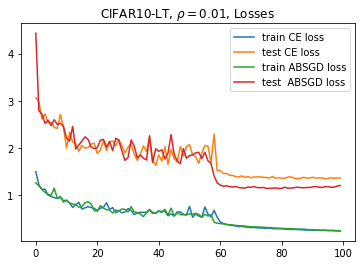

In [142]:
import matplotlib.pyplot as plt
plt.plot(np.load('CE_train_loss_arr.npy'), label = 'train CE loss')
plt.plot(np.load('CE_val_loss_arr.npy'), label = 'test CE loss')
plt.plot(train_loss_arr, label = 'train ABSGD loss')
plt.plot(val_loss_arr, label = 'test  ABSGD loss')
# plt.plot(train_loss_arr_ABSGD, label = 'train ABSGD loss')
# plt.plot(val_loss_arr_ABSGD, label = 'test  ABSGD loss')
plt.title(r'CIFAR10-LT, $\rho = 0.01$, Losses')
plt.legend()
plt.show()

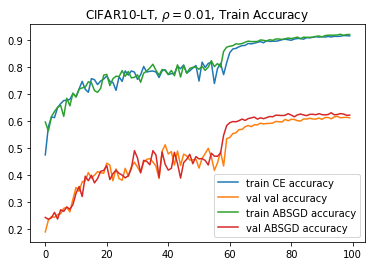

In [146]:
plt.plot(np.load('CE_train_acc_arr.npy'), label = 'train CE accuracy')
plt.plot(np.load('CE_val_acc_arr.npy'), label = 'val val accuracy')
plt.plot(train_acc_arr, label = 'train ABSGD accuracy')
plt.plot(val_acc_arr, label = 'val ABSGD accuracy')
plt.legend()
plt.title(r'CIFAR10-LT, $\rho = 0.01$, Train Accuracy')
plt.show()